<a href="https://colab.research.google.com/github/jonatanriq/oceanografia/blob/main/analisando_dados_elnino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importanto o pacote pandas e lendo o dataset do El Niño.

Esse dataset do El Niño foi é relativo à todo o globo. Portanto, ele pode ser o ponto de partida para análises mais elaboradas. Aqui, apliquei apenas uma rápida visualização dos dados, mas poderia aplicar uma metodologia mais complexa, como verificação de outliers, correlação entre os dados atmosféricos e oceânicos e outras análises...

In [1]:
import pandas as pd
nino = pd.read_csv('/content/elnino.csv')

## Tratando o Dataset

* Retrabalhando colunas
* Setando índices (em *datetime*)
* Alterando os tipos de coluna

Isso é necessário para melhor visualização e *slicing*.



In [2]:
# colocando o titulo das colunas para minusculo
nino = nino[nino.columns[:]].set_axis([nome.lower() for nome in nino.columns[:]], axis=1, inplace=False)

# tirando os espaços dos nomes das colunas
nino = nino[nino.columns[:]].set_axis([nome.strip() for nome in nino.columns[:]], axis=1, inplace=False)

# colocando o índice em datetime
nino.index = pd.to_datetime(nino['year'].astype(str)+'-'+nino['month'].astype(str)+'-'+nino['day'].astype(str))

# removendo as colunas que não vou usar
nino.drop([nomes for nomes in nino.columns[0:5]], axis=1, inplace=True)

# transformando as colunas em numérico
nino = nino[nino.columns[:]].apply(pd.to_numeric, errors='coerce', axis=1)

# removendo colunas que tenham mais de 30% de valores faltantes
for nome in nino.columns[:]:
  if nino[nome].isnull().sum()/len(nino[nome]) > 0.3: 
    nino.drop(nome, axis=1,inplace=True)

nino

,latitude,longitude,zonal winds,meridional winds,air temp,sea surface temp
1980-03-07,-0.02,-109.46,-6.8,0.7,26.14,26.24
1980-03-08,-0.02,-109.46,-4.9,1.1,25.66,25.97
1980-03-09,-0.02,-109.46,-4.5,2.2,25.69,25.28
1980-03-10,-0.02,-109.46,-3.8,1.9,25.57,24.31
1980-03-11,-0.02,-109.46,-4.2,1.5,25.30,23.19
...,...,...,...,...,...,...
1998-06-11,8.96,-140.33,-5.1,-0.4,26.04,28.14
1998-06-12,8.96,-140.32,-4.3,-3.3,25.80,27.87
1998-06-13,8.95,-140.34,-6.1,-4.8,27.17,27.93
1998-06-14,8.96,-140.33,-4.9,-2.3,27.36,28.03


## Realizando a plotagem

Utilizo o pacote matplotlib juntamente com o seaborn

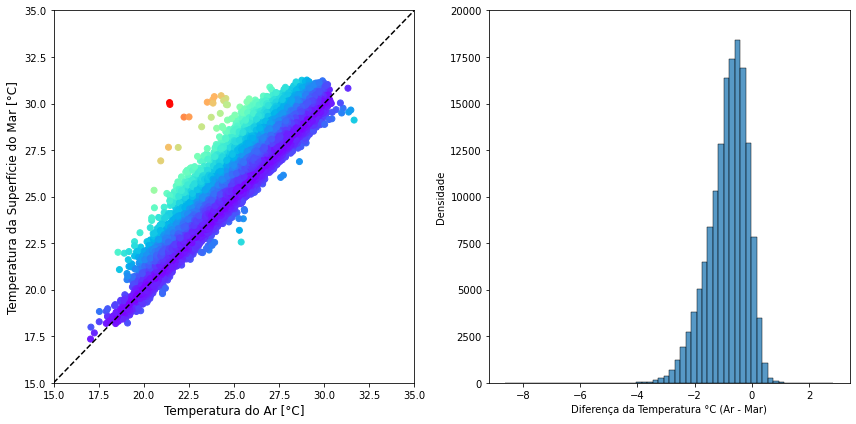

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, [ax1,ax2] = plt.subplots(figsize=(12,6), ncols=2)

# criando um método para plotar as diferenças nas cores 
diff = nino[nino.columns[-2]]- nino[nino.columns[-1]]

ax1.scatter(nino[nino.columns[-2]], nino[nino.columns[-1]], c=np.abs(diff), cmap='rainbow')
ax1.plot([0,1],[0,1], '--k', transform=ax1.transAxes)
ax1.set_xlim(15,35)
ax1.set_ylim(15,35)
ax1.set_xlabel('Temperatura do Ar [°C]', fontsize=12)
ax1.set_ylabel('Temperatura da Superfície do Mar [°C]', fontsize=12)

# o histograma dos dados
histograma = sns.histplot(diff, ax=ax2, bins=60)
ax2.set_xlabel('teste')
ax2.set_ylabel('Densidade')
ax2.set_xlabel('Diferença da Temperatura °C (Ar - Mar)')
ax2.vlines(0,-1,1,color='k')
ax2.set_ylim(0,20000)

plt.tight_layout()
plt.show()

## Realizando a interpolação dos valores

Aqui eu uso método [resample do pandas](https://https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) para tratar os valores faltantes. Utilizo a média diária pra fazer isso.

In [5]:
airtmp_interp = nino[nino.columns[-2]].resample('1D').mean().interpolate(method ='linear', limit_direction ='forward')
sst_interp = nino[nino.columns[-1]].resample('1D').mean().interpolate(method ='linear', limit_direction ='forward')

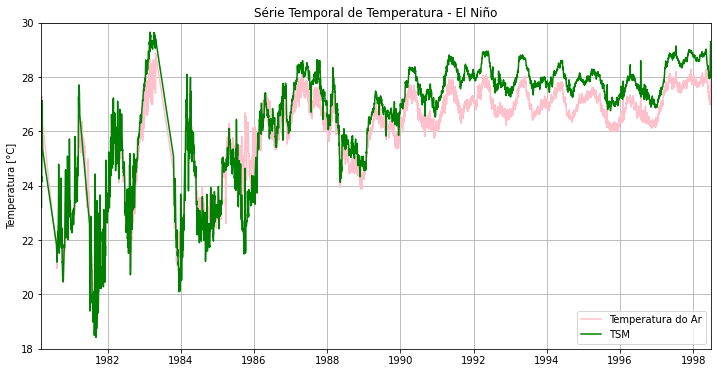

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(airtmp_interp, color='pink', linestyle='-', label='Temperatura do Ar')
ax.plot(sst_interp, color='green', linestyle='-', label='TSM')
plt.ylim(18,30)
plt.xlim(sst_interp.index.min(), sst_interp.index.max())
plt.legend()
plt.ylabel('Temperatura [°C]')
plt.title('Série Temporal de Temperatura - El Niño')
plt.grid()

## Descobrindo a variância de ambas as séries

Calculo a variância através da média móvel de 1 ano dos valores.

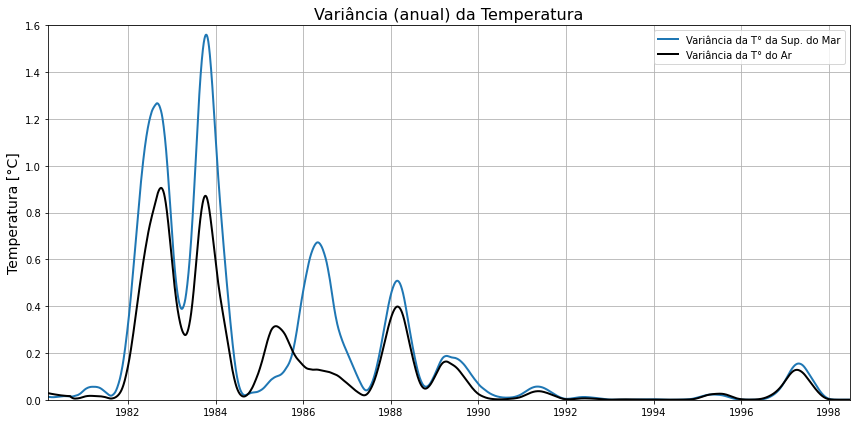

In [ ]:
ws = 365 # 1 ano de janela 
media_movel_sst = sst_interp.rolling(ws, center=True, min_periods=1).mean()
var_sst = media_movel_sst.rolling(ws, center=True, min_periods=1).var()

media_movel_air = airtmp_interp.rolling(ws, center=True, min_periods=1).mean()
var_air = media_movel_air.rolling(ws, center=True, min_periods=1).var()

plt.figure(figsize=(12,6))
plt.plot(var_sst, linewidth=2, label='Variância da T° da Sup. do Mar')
plt.plot(var_air, color='k', linestyle='-', linewidth=2, label='Variância da T° do Ar')
plt.xlim(var_air.index.min(), var_air.index.max())
plt.ylim(0,1.6)
plt.ylabel('Temperatura [°C]', fontsize=14)
plt.title('Variância (anual) da Temperatura', fontsize=16)
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()